<a href="https://colab.research.google.com/github/RostislavKorst/Generative-Models-2025/blob/main/Assignment%202/2_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [38]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [39]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100.0%
100.0%
100.0%
100.0%


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542488, -0.60313725, -0.47084969,
        -0.33856213, -0.20627451, -0.07398695,  0.05830061,  0.19058824,
         0.32287574,  0.45516336,  0.58745098,  0.71973848,  0.8520261 ,
         0.98431373]),
 <BarContainer object of 15 artists>)

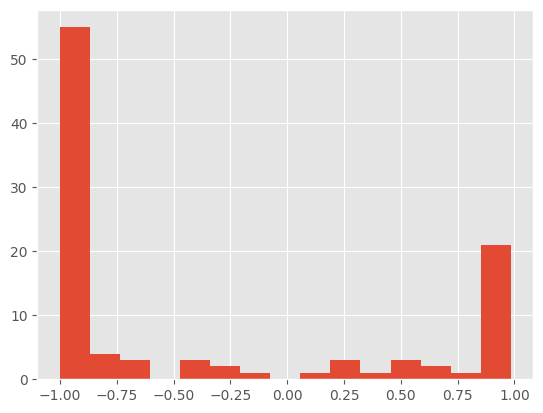

In [40]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [41]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x + 1) / 2


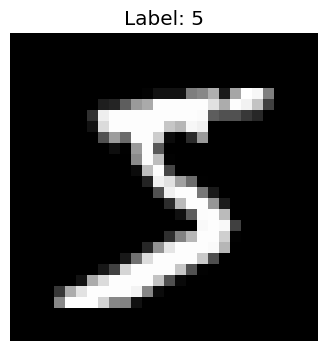

In [42]:
# show image sample with matplotlib
img, label = mnist_dataset[0]
plt.figure(figsize=(4, 4))
plt.imshow(denorm(img).squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [43]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [44]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        # set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        # set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = F.leaky_relu(self.linear1(x), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = torch.sigmoid(self.linear3(x))
        return x

### Create the Generator and Discriminator

In [45]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size)

# create new Discriminator model
D = Discriminator(image_size, hidden_size)

print("Generator:", G)
print("\nDiscriminator:", D)

Generator: Generator(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
)

Discriminator: Discriminator(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)


In [46]:
# show the output of model
y = G(torch.randn(2, latent_size))

In [47]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

# Define the optimizer for generator and discriminator
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))

Discriminator Training

In [48]:
def reset_grad():
    # reset gradient for optimizer of generator and discriminator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(D_model, G_model, images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [49]:
def train_generator(G_model):
    # Generate fake images and calculate loss
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [50]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [51]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, fake_images = train_generator(G)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 1.1104, g_loss: 0.9135, D(x): 0.55, D(G(z)): 0.40
Epoch [0/300], Step [400/600], d_loss: 0.6338, g_loss: 1.8384, D(x): 0.88, D(G(z)): 0.39
Epoch [0/300], Step [600/600], d_loss: 0.5101, g_loss: 2.8035, D(x): 0.90, D(G(z)): 0.32
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.4346, g_loss: 3.2629, D(x): 0.93, D(G(z)): 0.28
Epoch [1/300], Step [400/600], d_loss: 0.3742, g_loss: 2.5044, D(x): 0.82, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 0.3964, g_loss: 2.6145, D(x): 0.91, D(G(z)): 0.24
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2463, g_loss: 3.2125, D(x): 0.89, D(G(z)): 0.08
Epoch [2/300], Step [400/600], d_loss: 0.2354, g_loss: 2.8511, D(x): 0.91, D(G(z)): 0.09
Epoch [2/300], Step [600/600], d_loss: 0.4938, g_loss: 1.7280, D(x): 0.76, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1849, g_loss: 4.0728, D(x): 0.89, D(G(z)): 0.03
Epoch [3/300], Step [400/6

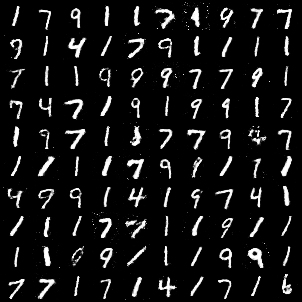

In [53]:
# show output after epochs training
from IPython.display import Image as IPImage
IPImage(os.path.join(sample_dir, "fake_images-0225.png"))

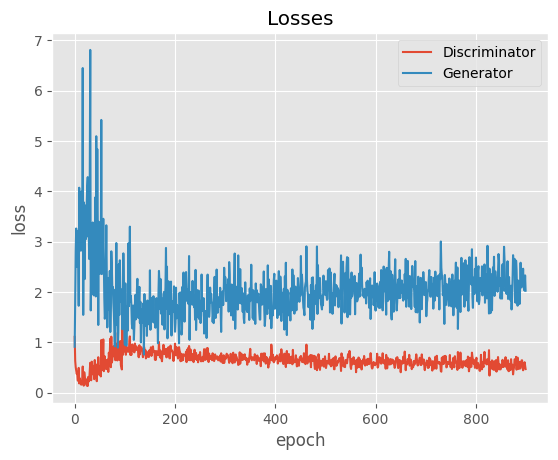

In [54]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

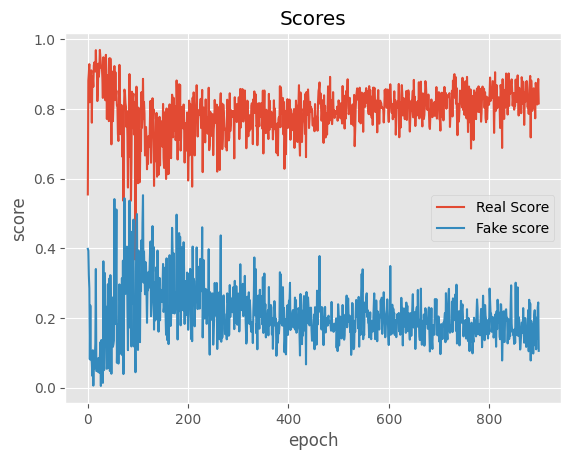

In [55]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [56]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100.0%


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124187, -0.74797386, -0.68470585, -0.62143791,
        -0.55816996, -0.49490196, -0.43163398, -0.368366  , -0.30509806,
        -0.24183005, -0.17856205, -0.1152941 , -0.05202615,  0.01124185,
         0.07450986]),
 <BarContainer object of 15 artists>)

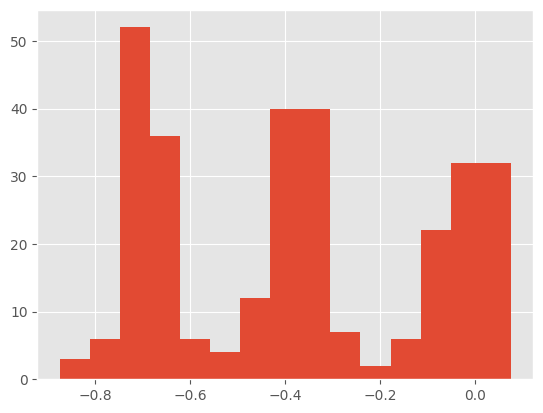

In [57]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

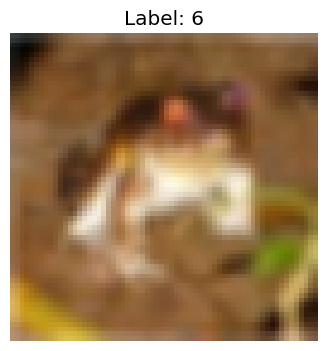

In [58]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return (img + 1) / 2

# show image sample with matplotlib
img, label = cifar_dataset[0]
plt.figure(figsize=(4, 4))
plt.imshow(denorm(img).permute(1, 2, 0))
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


In [59]:
# create the dataloader
data_loader = torch.utils.data.DataLoader(
    dataset=cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    drop_last=True
)

### DCGAN implementation

In [60]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # nz x 1 x 1 -> ngf*8 x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # ngf*8 x 4 x 4 -> ngf*4 x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # ngf*4 x 8 x 8 -> ngf*2 x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # ngf*2 x 16 x 16 -> ngf x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # ngf x 32 x 32 -> nc x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is nc x 64 x 64 -> ndf x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 32 x 32 -> ndf*2 x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 16 x 16 -> ndf*4 x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 8 x 8 -> ndf*8 x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 4 x 4 -> 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [61]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf)

# Apply weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

DCG.apply(weights_init)
DCD.apply(weights_init)

print("Generator:", DCG)
print("\nDiscriminator:", DCD)

Generator: DCGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): 

In [62]:
# show the output of model (need to reshape input to nz x 1 x 1)
y = DCG(torch.randn(2, CFG.nz, 1, 1))
print("Generator output shape:", y.shape)

Generator output shape: torch.Size([2, 3, 64, 64])


In [63]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

# Define the optimizer for generator and discriminator
dc_d_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
dc_g_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [64]:
# training functions for DCGAN
def dc_reset_grad():
    dc_d_optimizer.zero_grad()
    dc_g_optimizer.zero_grad()


def train_dc_discriminator(DCD_model, DCG_model, images):
    batch_size = images.size(0)
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1, 1, 1).to(CFG.device)
    fake_labels = torch.zeros(batch_size, 1, 1, 1).to(CFG.device)

    # Loss for real images
    outputs = DCD_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(z)
    outputs = DCD_model(fake_images.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    dc_reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    dc_d_optimizer.step()

    return d_loss, real_score, fake_score


def train_dc_generator(DCG_model, DCD_model, batch_size):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(z)
    labels = torch.ones(batch_size, 1, 1, 1).to(CFG.device)
    
    # calculate the generator loss
    outputs = DCD_model(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    dc_reset_grad()

    # Backprop and optimize
    g_loss.backward()
    dc_g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [65]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch (keep images in their original shape for convolutions)
        images = images.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_dc_discriminator(DCD, DCG, images)

        # Train the generator
        g_loss, fake_images = train_dc_generator(DCG, DCD, batch_size)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

Epoch [0/300], Step [200/390], d_loss: 0.9637, g_loss: 2.7615, D(x): 0.49, D(G(z)): 0.01
Saving fake_images-0001.png


In [ ]:
# show your results!
from IPython.display import Image as IPImage

# Show a sample generated image
IPImage(os.path.join(CFG.sample_dir, "fake_images-0100.png"))

In [ ]:
# show the discriminator loss and generator loss for DCGAN
plt.figure(figsize=(10, 5))
plt.plot(d_losses, "-", label='Discriminator')
plt.plot(g_losses, "-", label='Generator')
plt.xlabel("Step (x200)")
plt.ylabel("Loss")
plt.legend()
plt.title("DCGAN Losses")
plt.show()


In [ ]:
# plot the accuracy of discriminator for DCGAN
plt.figure(figsize=(10, 5))
plt.plot(real_scores, "-", label='Real Score')
plt.plot(fake_scores, "-", label='Fake Score')
plt.xlabel("Step (x200)")
plt.ylabel("Score")
plt.legend()
plt.title("DCGAN Discriminator Scores")
plt.show()
